# Sentiment Analysis with LoRA

In [1]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

# --- Standard Library ---
import os
from dataclasses import dataclass

# --- Third-Party Libraries ---
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report

# --- Local Application/Module Imports ---
from data_loader.data_loader import load_and_split_data, load_submission_data
from data_preprocessing.dataset_dataloader import create_data_loader
import visualizations.visualizations
importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

import models.models
importlib.reload(models.models)
from models.models import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
@dataclass
class Config:
    # problem_type: str
    batch_size: int
    model: str
    seed: int
    lr: float
    epochs: int
    dropout: float
    attention_dropout: float
    patience: int
    lora_r: int
    lora_alpha: float
    device: str
    num_classes: int
    max_len: int


# Determine the best available device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

config = Config(
    # problem_type="multi_label_classification",
    batch_size=16,
    model="FacebookAI/roberta-large",#"cardiffnlp/twitter-roberta-base-sentiment-latest", #distilbert/distilbert-base-uncased",
    # "bert-large-cased", # "microsoft/deberta-v3-large", # "google/flan-t5-small", # TODO: small has 80 million tokens, but we can do ablation study going up to 11B for xxl model: https://huggingface.co/google/flan-t5-xxl
    seed=42,
    lr=3e-5,
    epochs=15,
    dropout=0.1,
    attention_dropout=0.1,
    patience=3,
    # For LoRA
    lora_r=16,
    lora_alpha=32,  # a common choice is alpha = 2 * rank
    device=device,
    num_classes=3,
    max_len=64,
)

def set_seed(seed: int) -> None:
    import os
    import random

    import numpy as np

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


set_seed(config.seed)

Random seed set as 42


In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(config.model)
print(f"""
{tokenizer.name_or_path=}
{tokenizer.vocab_size=}
{tokenizer.model_max_length=}
""")


tokenizer.name_or_path='FacebookAI/roberta-large'
tokenizer.vocab_size=50265
tokenizer.model_max_length=512



In [4]:
from data_preprocessing.data_preprocessing import minimal_llm_preprocess

train_df, val_df, test_df = load_and_split_data()

# train_df = minimal_llm_preprocess(train_df)
# val_df = minimal_llm_preprocess(val_df)
# test_df = minimal_llm_preprocess(test_df)

train_data_loader = create_data_loader(train_df, tokenizer, config.max_len, config.batch_size)
val_data_loader = create_data_loader(val_df, tokenizer, config.max_len, config.batch_size)
test_data_loader = create_data_loader(test_df, tokenizer, config.max_len, config.batch_size)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
model = load_blank_model(config)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Making sure everything works:

-------

In [6]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [7]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 64])
torch.Size([16, 64])
torch.Size([16])


In [8]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)  # batch size x seq length
print(attention_mask.shape)  # batch size x seq length

torch.Size([16, 64])
torch.Size([16, 64])


In [9]:
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
probs = F.softmax(outputs.logits, dim=1).detach().cpu().numpy()

In [10]:
probs

array([[0.48711503, 0.26243293, 0.250452  ],
       [0.49163306, 0.2576795 , 0.25068748],
       [0.49224928, 0.25845617, 0.2492945 ],
       [0.4611974 , 0.2773104 , 0.2614922 ],
       [0.49148142, 0.2574048 , 0.25111374],
       [0.45804808, 0.28159967, 0.26035222],
       [0.5077322 , 0.241946  , 0.25032184],
       [0.48308435, 0.26245466, 0.25446108],
       [0.4687895 , 0.27836606, 0.25284448],
       [0.51996636, 0.2458942 , 0.23413941],
       [0.46794268, 0.27688417, 0.25517312],
       [0.49720687, 0.2602044 , 0.2425888 ],
       [0.49320522, 0.25702983, 0.24976496],
       [0.47106808, 0.27447966, 0.25445226],
       [0.5052319 , 0.24242628, 0.25234184],
       [0.49185905, 0.2562855 , 0.25185543]], dtype=float32)

-------

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr)
total_steps = len(train_data_loader) * config.epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [12]:
# from sklearn.utils.class_weight import compute_class_weight
#
# # Compute weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df.labels),
#     y=train_df.labels
# )
#
# # Convert to tensor and move to device
# weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#
# # Use in loss function
# loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

In [13]:
%%time

from collections import defaultdict
import torch

history = defaultdict(list)
best_f1 = 0
best_accuracy = 0
patience = config.patience  # Number of epochs to wait after no improvement
epochs_without_improvement = 0

for epoch in range(config.epochs):

    print(f'Epoch {epoch + 1}/{config.epochs}')
    print('-' * 10)

    train_f1, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
    )

    print(f'Train loss {train_loss:.4f} f1-score {train_f1:.4f}')

    val_f1, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
    )

    print(f'Val   loss {val_loss:.4f} f1-score {val_f1:.4f}')
    print()

    history['train_f1'].append(train_f1)
    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_f1)
    history['val_loss'].append(val_loss)

    if val_f1 > best_f1:
        torch.save(model.state_dict(), 'roberta_large_15_epoch_batch_16_dropout_0_3.bin')
        print(f'Validation F1 improved from {best_f1:.4f} to {val_f1:.4f}. Model saved.')
        best_f1 = val_f1
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f'No improvement in F1 for {epochs_without_improvement} epoch(s).')

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break


Epoch 1/15
----------


Train loss 0.6289 f1-score 0.7360


Val   loss 0.5697 f1-score 0.7786

Validation F1 improved from 0.0000 to 0.7786. Model saved.
Epoch 2/15
----------


Train loss 0.4772 f1-score 0.8129


Val   loss 0.6030 f1-score 0.7830

Validation F1 improved from 0.7786 to 0.7830. Model saved.
Epoch 3/15
----------


Train loss 0.3998 f1-score 0.8612


Val   loss 0.7038 f1-score 0.7684

No improvement in F1 for 1 epoch(s).
Epoch 4/15
----------


Train loss 0.3600 f1-score 0.8825


Val   loss 0.7702 f1-score 0.7688

No improvement in F1 for 2 epoch(s).
Epoch 5/15
----------


Train loss 0.3197 f1-score 0.9029


Val   loss 0.7420 f1-score 0.7708

No improvement in F1 for 3 epoch(s).
Early stopping triggered after 3 epochs without improvement.
CPU times: user 1h 33min 4s, sys: 26min 36s, total: 1h 59min 41s
Wall time: 2h 48min 50s


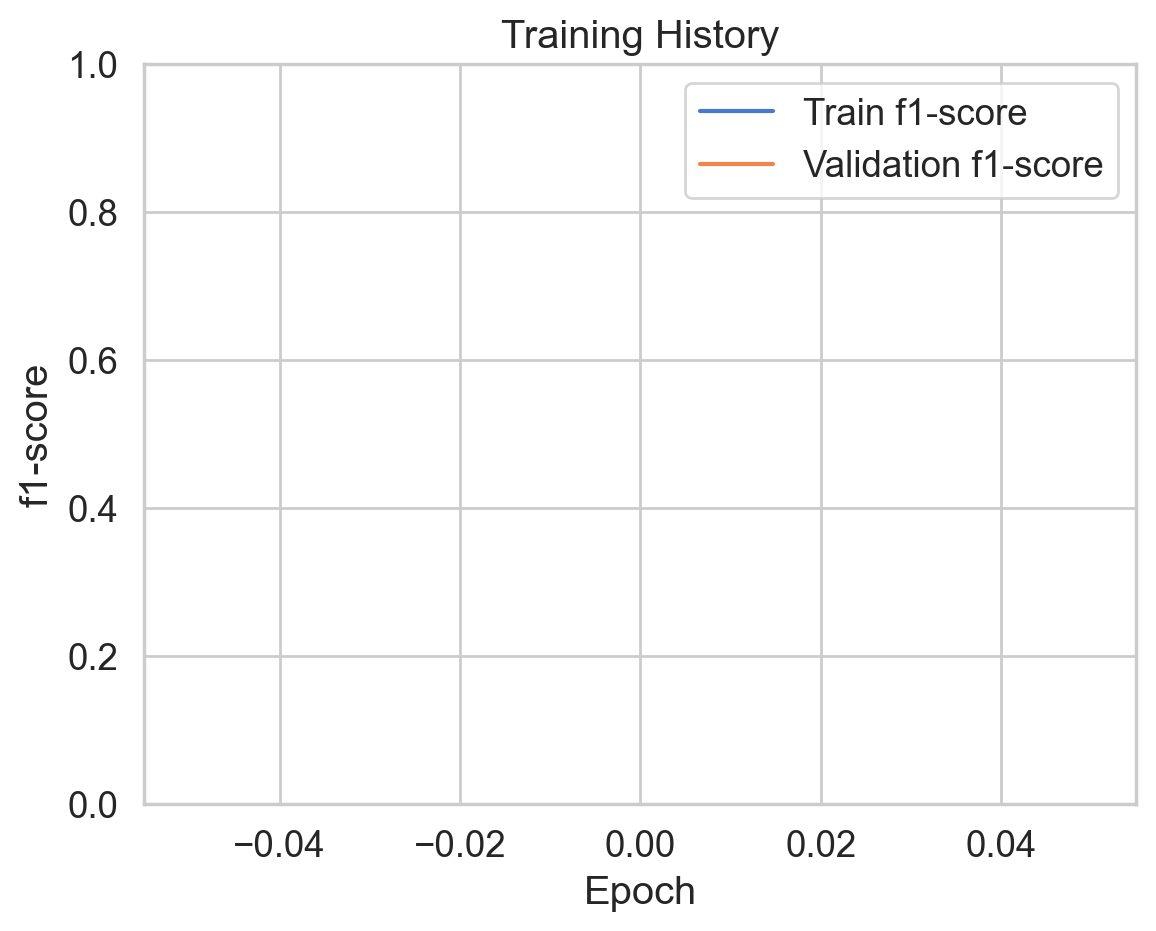

In [14]:
plot_training_history(history)

## Evaluation

In [15]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device
)

test_acc.item()

0.7798412085107703

In [16]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader,
    device
)

In [17]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, labels=[0, 1, 2], target_names=class_names))

              precision    recall  f1-score   support

    negative       0.73      0.77      0.75      2191
     neutral       0.84      0.78      0.81      4915
    positive       0.76      0.81      0.78      3104

    accuracy                           0.79     10210
   macro avg       0.77      0.79      0.78     10210
weighted avg       0.79      0.79      0.79     10210



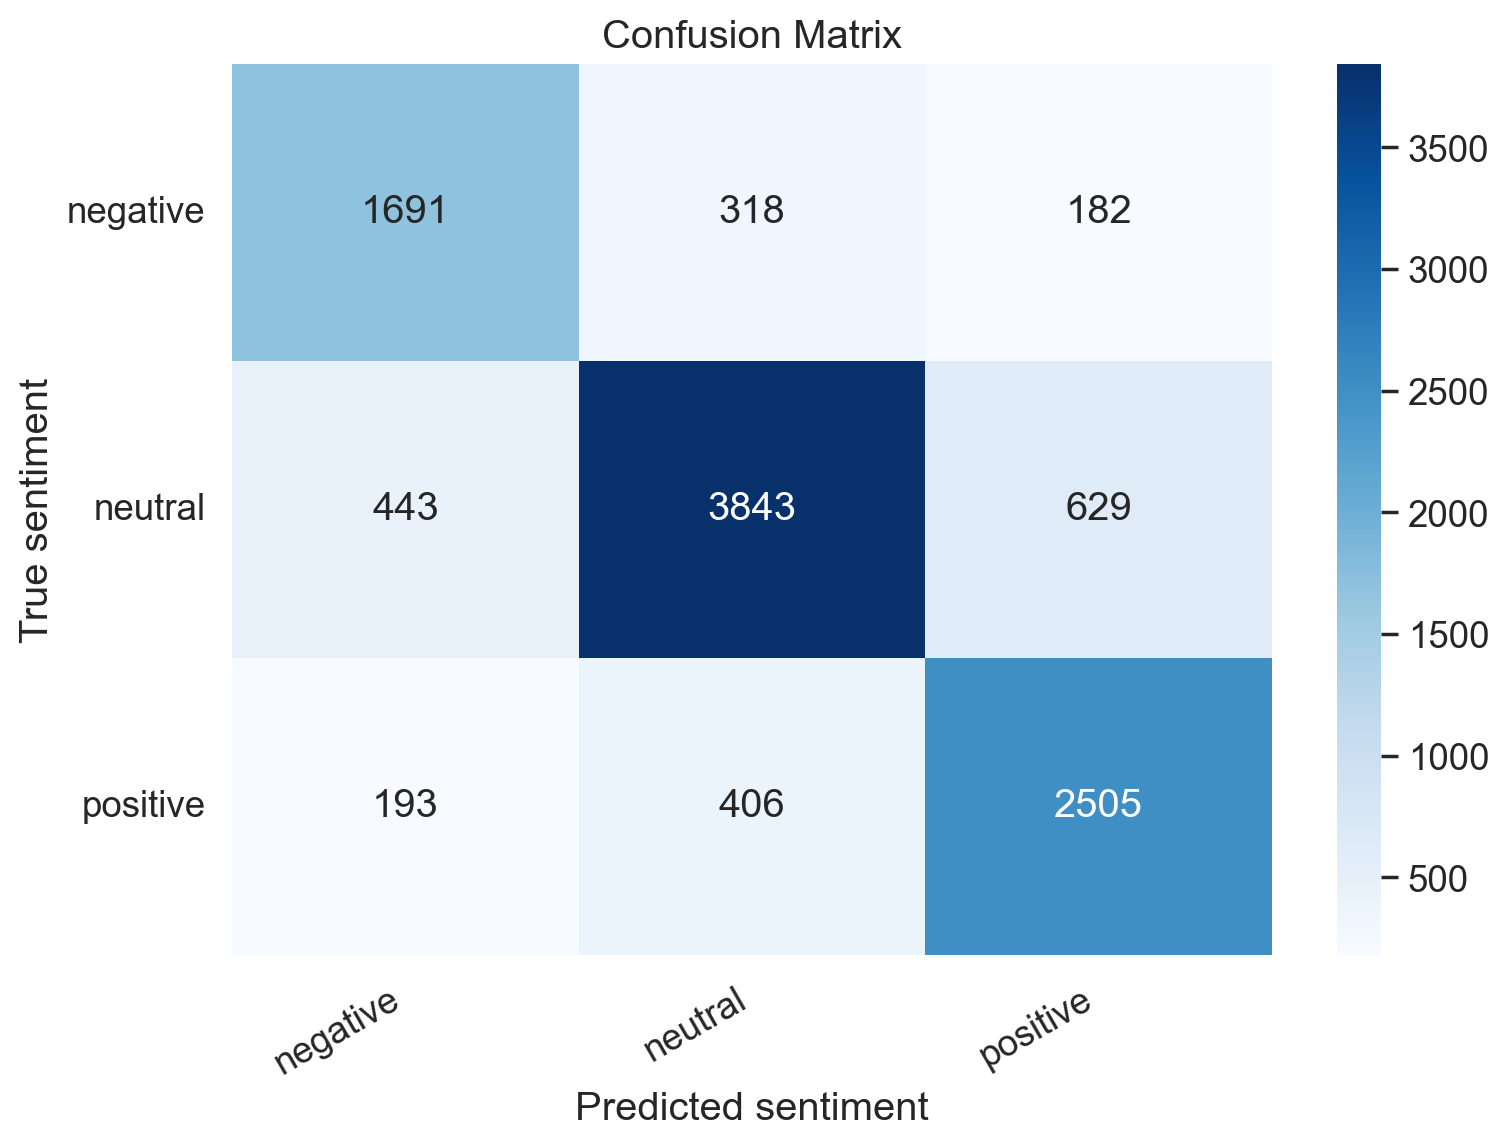

In [18]:
plot_confusion_matrix(y_test, y_pred, class_names)

ANALYZE 193 and 182

## Submission

In [19]:
submission_df = load_submission_data()

submission_data_loader = create_data_loader(submission_df, tokenizer, config.max_len, config.batch_size)

In [20]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    submission_data_loader,
    device
)

In [21]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(y_pred, label_map=label_map)

Submission file saved to ../submissions/submission.csv


In [22]:
train_df.size

163354

In [23]:
val_df.size

20420

In [24]:
train_df

,text,labels
id,,
93866,I'm just glad I wasn't paying the bill.,0
49185,We decided to give it a try.,1
8401,Food was tasty.,2
89069,When ` science fiction ' takes advantage of th...,0
51789,I went here to have my iPhone 6 screen replaced.,1
...,...,...
38939,I got the sundae and asked for extra chocolate...,1
26923,We had to go there because they said the one i...,1
2436,Asking how we met like it's their business.,1
